In [1]:
# Importação das bibliotecas principais
import pandas as pd
import numpy as np
import time

# Importação de bibliotecas para o modelo e otimização
import lightgbm as lgbm
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Importação de bibliotecas de visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Configuração para exibir todas as colunas no output do Pandas
pd.set_option('display.max_columns', None)

## Importação e Ajuste da Base de Dados
Carregamos o arquivo `vendas.csv`, que contém o histórico de vendas por produto, 
e realizamos algumas transformações para preparar os dados para análise.

In [2]:
# Carregamento dos dados de vendas
hist = pd.read_csv('./data/vendas.csv')
hist

,sku,data_venda,venda
0,336,2024-01-14,15
1,336,2024-01-18,28
2,336,2024-01-20,34
3,336,2024-01-23,32
4,336,2024-01-25,27
...,...,...,...
135221,2883,2024-02-11,12
135222,4593,2024-02-13,23
135223,774,2024-02-13,25
135224,2580,2024-02-13,16


In [3]:
# Conversão da coluna 'data_venda' para o formato de data
hist['data_venda'] = pd.to_datetime(hist['data_venda'])

hist['data_venda'].describe()

count                           135226
mean     2024-02-25 15:48:34.001745152
min                2024-01-14 00:00:00
25%                2024-02-04 00:00:00
50%                2024-02-26 00:00:00
75%                2024-03-18 00:00:00
max                2024-04-08 00:00:00
Name: data_venda, dtype: object

In [4]:
# Criação de um DataFrame com todas as datas no período analisado
# Aqui, geramos uma série temporal contínua para garantir que todos os dias estejam representados,
# mesmo que não haja vendas registradas para algum produto específico nesses dias.
datas = pd.DataFrame({'data_venda': pd.date_range(start=hist['data_venda'].min(), 
                                                  end=hist['data_venda'].max()), 
                      'key': 1})

# Criação de um DataFrame com todos os SKUs únicos
# Esse DataFrame nos ajuda a garantir que todos os produtos estejam representados em todas as datas.
prods = pd.DataFrame({'sku': hist['sku'].unique(), 'key': 1})

# Geração de um DataFrame de base para cruzar SKUs com todas as datas
# Aqui, fazemos o produto cartesiano entre datas e SKUs para preencher as lacunas de datas sem vendas.
hist_ajustado = pd.merge(prods, datas, on='key', how='left').drop(columns='key')

# Junção dos dados originais com a estrutura de datas e SKUs completos
# Realizamos uma junção (merge) com o histórico original, preenchendo com zero onde não há registros de venda.
hist_completo = pd.merge(hist_ajustado, hist, on=['sku', 'data_venda'], how='left').fillna(0)

# Liberação de memória ao excluir DataFrames temporários
del datas, prods, hist_ajustado

# Adição da coluna de semana de venda
# Criamos uma nova coluna para indicar a semana de venda, baseada na data inicial de cada semana.
hist_completo['semana_venda'] = hist_completo['data_venda'].dt.to_period('W-MON').dt.start_time

# Agrupamento por SKU e semana
# Agrupamos os dados por SKU e semana, somando as vendas semanais. Esse agrupamento é útil para modelos de previsão semanais.
hist_semanal = hist_completo.groupby(['sku', 'semana_venda']).agg({'venda': 'sum'}).reset_index()

# Visualização do DataFrame semanal
hist_semanal

,sku,semana_venda,venda
0,1,2024-01-09,0.0
1,1,2024-01-16,107.0
2,1,2024-01-23,54.0
3,1,2024-01-30,74.0
4,1,2024-02-06,89.0
...,...,...,...
74043,5696,2024-03-05,0.0
74044,5696,2024-03-12,0.0
74045,5696,2024-03-19,0.0
74046,5696,2024-03-26,0.0


In [5]:
# Como a primeira semana da base de dados está incompleta (os dados começam no dia 14. e não no dia 09), vamos removê-la para não causar distorções.
hist_semanal = hist_semanal.loc[hist_semanal['semana_venda'] > '2024-01-09']

In [6]:
# Análise descritiva da coluna 'semana_venda'
# Verificamos a distribuição da coluna de semanas para entender melhor o intervalo de análise.
hist_semanal['semana_venda'].describe()

count                  68352
mean     2024-02-23 12:00:00
min      2024-01-16 00:00:00
25%      2024-02-04 06:00:00
50%      2024-02-23 12:00:00
75%      2024-03-13 18:00:00
max      2024-04-02 00:00:00
Name: semana_venda, dtype: object

In [7]:
hist_semanal['semana_venda'].unique()

<DatetimeArray>
['2024-01-16 00:00:00', '2024-01-23 00:00:00', '2024-01-30 00:00:00',
 '2024-02-06 00:00:00', '2024-02-13 00:00:00', '2024-02-20 00:00:00',
 '2024-02-27 00:00:00', '2024-03-05 00:00:00', '2024-03-12 00:00:00',
 '2024-03-19 00:00:00', '2024-03-26 00:00:00', '2024-04-02 00:00:00']
Length: 12, dtype: datetime64[ns]

## Criação das Bases de Treino e Teste
Aqui, definimos os períodos de treino e teste. 
Dividimos o conjunto de dados semanal para focar em previsões semanais e avaliações de performance.

In [8]:
# Definindo os períodos para treino e teste (fase de desenvolvimento e performance)
treino_inicio_desenvolvimento = '2024-01-16'
treino_fim_desenvolvimento = '2024-03-19'

teste_inicio_desenvolvimento = '2024-01-23'
teste_fim_desenvolvimento = '2024-03-26'

treino_performance = '2024-03-26'
teste_performance = '2024-04-02'

# Criando conjuntos de dados para a fase de desenvolvimento (treino e teste)
desenv_treino = hist_semanal[(hist_semanal['semana_venda'] >= treino_inicio_desenvolvimento) & 
                             (hist_semanal['semana_venda'] <= treino_fim_desenvolvimento)]
desenv_teste = hist_semanal[(hist_semanal['semana_venda'] >= teste_inicio_desenvolvimento) & 
                            (hist_semanal['semana_venda'] <= teste_fim_desenvolvimento)]

# Criando conjuntos de dados para a avaliação de performance
performance_treino = hist_semanal[hist_semanal['semana_venda'] == treino_performance]
performance_teste = hist_semanal[hist_semanal['semana_venda'] == teste_performance]

## Criação de Variáveis Preditivas e Normalização dos Dados
A função `criar_variaveis_preditivas` gera variáveis baseadas no histórico de vendas, como soma, média, 
mínimo e máximo das últimas N semanas, além de variáveis de tendência. Também calculamos o coeficiente de variação 
e o número de semanas desde a última vez que o produto não teve venda. Após a criação dessas variáveis, normalizamos os dados.

In [9]:
# Função para criação de variáveis preditivas baseadas em lags de vendas
def criar_variaveis_preditivas(df, lags):
    # Ordenar o DataFrame para garantir a correta sequência temporal
    df = df.sort_values(by=["sku", "semana_venda"]).reset_index(drop=True)

    # Garantir que não haja duplicatas na lista de lags
    lags = sorted(list(set(lags)))

    # Função para calcular inclinação da tendência (últimas N semanas)
    def calcular_tendencia(series):
        if series.shape[0] < 2:
            return 0
        X = np.arange(series.shape[0]).reshape(-1, 1)
        model = LinearRegression()
        model.fit(X, series)
        return model.coef_[0]

    # Criar a variável 'vlr_ult_semana' apenas uma vez, representando o valor da semana atual
    df['vlr_ult_semana'] = df.groupby('sku')['venda'].transform(lambda x: x.shift(0))
    
    for lag in lags:
        # Ignorar o lag 1, já que ele é tratado como 'vlr_ult_semana'
        if lag == 1:
            continue

        # Para os outros lags, calcular as estatísticas das últimas semanas, incluindo a semana atual
        df[f'soma_ult_{lag}_semanas'] = df.groupby('sku')['venda'].rolling(window=lag, min_periods=1).sum().reset_index(0, drop=True)
        df[f'media_ult_{lag}_semanas'] = df.groupby('sku')['venda'].rolling(window=lag, min_periods=1).mean().reset_index(0, drop=True)
        df[f'min_ult_{lag}_semanas'] = df.groupby('sku')['venda'].rolling(window=lag, min_periods=1).min().reset_index(0, drop=True)
        df[f'max_ult_{lag}_semanas'] = df.groupby('sku')['venda'].rolling(window=lag, min_periods=1).max().reset_index(0, drop=True)
        df[f'desv_pad_ult_{lag}_semanas'] = df.groupby('sku')['venda'].rolling(window=lag, min_periods=1).std().reset_index(0, drop=True).fillna(0)

        # Coeficiente de variação (desvio padrão / média)
        df[f'coef_var_ult_{lag}_semanas'] = df[f'desv_pad_ult_{lag}_semanas'] / df[f'media_ult_{lag}_semanas']
        df[f'coef_var_ult_{lag}_semanas'] = df[f'coef_var_ult_{lag}_semanas'].fillna(0)

        # Calcular a tendência
        df[f'tend_ult_{lag}_semanas'] = df.groupby('sku')['venda'].rolling(window=lag, min_periods=1).apply(calcular_tendencia).reset_index(0, drop=True)

        # Contagem de semanas com vendas zero
        df[f'qtd_nao_vendas_ult_{lag}_semanas'] = df.groupby('sku')['venda'].rolling(window=lag, min_periods=1).apply(lambda x: (x == 0).sum()).reset_index(0, drop=True)

        # Quantidade de semanas desde a última semana com vendas zero
        def semanas_desde_nao_venda(series):
            rev_series = series[::-1]  # Inverter a série para contar a partir da semana mais recente
            idx = np.where(rev_series == 0)[0]
            if len(idx) == 0:
                return 999  # Se não houver vendas zero, imputar 999
            return idx[0]  # Retorna a quantidade de semanas até a última semana com 0 vendas

        df[f'tmp_desde_nao_vendas_ult_{lag}_semanas'] = df.groupby('sku')['venda'].rolling(window=lag, min_periods=1).apply(semanas_desde_nao_venda).reset_index(0, drop=True)

        # Razões com a última semana (semana atual)
        df[f'soma_ult_{lag}_semanas_ult_semana'] = df[f'soma_ult_{lag}_semanas'] / df['vlr_ult_semana']
        df[f'media_ult_{lag}_semanas_ult_semana'] = df[f'media_ult_{lag}_semanas'] / df['vlr_ult_semana']
        df[f'min_ult_{lag}_semanas_ult_semana'] = df[f'min_ult_{lag}_semanas'] / df['vlr_ult_semana']
        df[f'max_ult_{lag}_semanas_ult_semana'] = df[f'max_ult_{lag}_semanas'] / df['vlr_ult_semana']

        # Imputar -1 onde a última semana foi 0 para evitar divisão por zero
        df[f'soma_ult_{lag}_semanas_ult_semana'] = df[f'soma_ult_{lag}_semanas_ult_semana'].fillna(-1).replace(np.inf, -1)
        df[f'media_ult_{lag}_semanas_ult_semana'] = df[f'media_ult_{lag}_semanas_ult_semana'].fillna(-1).replace(np.inf, -1)
        df[f'min_ult_{lag}_semanas_ult_semana'] = df[f'min_ult_{lag}_semanas_ult_semana'].fillna(-1).replace(np.inf, -1)
        df[f'max_ult_{lag}_semanas_ult_semana'] = df[f'max_ult_{lag}_semanas_ult_semana'].fillna(-1).replace(np.inf, -1)

    # Selecionar apenas as linhas da última semana para cada SKU
    df_ult_semana = df.groupby('sku').tail(1).reset_index(drop=True)

    return df_ult_semana

In [10]:
# Aplicando a função para criar variáveis preditivas
df_train = criar_variaveis_preditivas(desenv_treino, list(range(2,11)))
df_test = criar_variaveis_preditivas(desenv_teste, list(range(2,11)))

# Separação das features e do target
X_train_raw = df_train.drop(columns=['sku', 'semana_venda', 'venda'])
y_train = performance_treino['venda']

X_test_raw = df_test.drop(columns=['sku', 'semana_venda', 'venda'])
y_test = performance_teste['venda']

C:\Users\rafae\AppData\Local\Temp\ipykernel_11820\3805449346.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'coef_var_ult_{lag}_semanas'] = df[f'desv_pad_ult_{lag}_semanas'] / df[f'media_ult_{lag}_semanas']
C:\Users\rafae\AppData\Local\Temp\ipykernel_11820\3805449346.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tend_ult_{lag}_semanas'] = df.groupby('sku')['venda'].rolling(window=lag, min_periods=1).apply(calcular_tendencia).reset_index(0, drop=True)
C:\Users\rafae\AppData\Local\Temp\ipykernel_11820\3805449

In [11]:
# Normalização dos dados
scaler = StandardScaler()

# Ajustando o scaler no conjunto de treino e transformando o treino e o teste
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_test = pd.DataFrame(scaler.transform(X_test_raw), columns=X_test_raw.columns)

# Criando as base de dados a serem utilizadas no processo de otimização de hiperparâmetros
X_train_ot, X_test_ot, y_train_ot, y_test_ot = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Forward Feature Selection
Para identificar as variáveis mais relevantes para o modelo, utilizamos a importância das features gerada por um modelo LightGBM inicial. 
As variáveis são ordenadas pela importância, e um processo iterativo é feito para adicionar uma variável por vez ao conjunto de treino, 
avaliando seu impacto na performance do modelo. Caso a inclusão de uma variável resulte em um MAE (Mean Absolute Error) menor do que o MAE 
anterior, a variável é mantida no conjunto de variáveis selecionadas. Caso contrário, a variável é descartada.

In [12]:
# Definindo os parâmetros iniciais do modelo LightGBM
params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'random_state': 42,
    'min_child_samples': int(0.01 * len(X_train_ot))
}

# Treinando o modelo inicial para obter a importância das variáveis
model = lgbm.LGBMRegressor(**params)
model.fit(X_train_ot, y_train_ot)

# Criando um DataFrame com as importâncias das variáveis e ordenando em ordem decrescente
feature_importances = pd.DataFrame({
    'feature': X_train_ot.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

# Lista ordenada das variáveis com base na importância
ordered_features = feature_importances['feature'].tolist()

# Inicializando a lista para armazenar as variáveis selecionadas e o melhor MAE encontrado
selected_features = []
best_mae = float('inf')  # Inicialmente, o MAE é definido como infinito para sempre haver uma melhoria inicial
start_time = time.time()  # Marcador do tempo inicial para monitoramento

# Loop para seleção de variáveis, adicionando uma por uma e avaliando o impacto no erro
for i, feature in enumerate(ordered_features, start=1):
    # Conjunto atual de features inclui as já selecionadas mais a nova feature a ser testada
    current_features = selected_features + [feature]
    
    # Treinando o modelo com o conjunto atual de variáveis
    model = lgbm.LGBMRegressor(**params)
    model.fit(X_train_ot[current_features], y_train_ot)
    
    # Prevendo no conjunto de teste e calculando o MAE
    y_pred = model.predict(X_test_ot[current_features])
    mae = mean_absolute_error(y_test_ot, y_pred)
    
    # Verificação se o MAE atual é melhor do que o melhor MAE encontrado até o momento
    if mae < best_mae:
        # Atualizando o melhor MAE e adicionando a feature à lista de selecionadas
        best_mae = mae
        selected_features.append(feature)
        status = "mantida"  # Marcação de status para a feature mantida
    else:
        status = "descartada"  # Marcação de status para a feature descartada
    
    # Calculando o tempo decorrido
    elapsed_time = (time.time() - start_time) / 60  # Tempo em minutos
    
    # Exibindo o status da feature atual, o MAE e o tempo decorrido
    print(f"Feature '{feature}' {status} (MAE: {mae:.4f}) | Tempo (min): {elapsed_time:.2f} | Iteração {i}/{len(ordered_features)}")

# Exibindo a lista final de variáveis selecionadas para a modelagem
print("\nLista de variáveis selecionadas para modelagem:")
print(selected_features)

Feature 'vlr_ult_semana' mantida (MAE: 24.5160) | Tempo (min): 0.00 | Iteração 1/118
Feature 'tend_ult_3_semanas' mantida (MAE: 23.9270) | Tempo (min): 0.01 | Iteração 2/118
Feature 'desv_pad_ult_3_semanas' descartada (MAE: 24.0820) | Tempo (min): 0.01 | Iteração 3/118
Feature 'tend_ult_2_semanas' mantida (MAE: 23.8110) | Tempo (min): 0.01 | Iteração 4/118
Feature 'desv_pad_ult_2_semanas' descartada (MAE: 23.9605) | Tempo (min): 0.01 | Iteração 5/118
Feature 'soma_ult_3_semanas' descartada (MAE: 23.9630) | Tempo (min): 0.02 | Iteração 6/118
Feature 'tend_ult_4_semanas' descartada (MAE: 23.8209) | Tempo (min): 0.02 | Iteração 7/118
Feature 'tend_ult_5_semanas' descartada (MAE: 24.1594) | Tempo (min): 0.02 | Iteração 8/118
Feature 'min_ult_9_semanas' mantida (MAE: 23.6884) | Tempo (min): 0.02 | Iteração 9/118
Feature 'min_ult_8_semanas' descartada (MAE: 23.7499) | Tempo (min): 0.03 | Iteração 10/118
Feature 'desv_pad_ult_6_semanas' mantida (MAE: 23.6059) | Tempo (min): 0.03 | Iteração 11

In [13]:
# Filtrando as variáveis no conjunto de treino e teste com base na seleção final
X_train = X_train[selected_features]
X_test = X_test[selected_features]

X_train_ot = X_train_ot[selected_features]
X_test_ot = X_test_ot[selected_features]

### Otimização de Hiperparâmetros com Optuna e Avaliação do Modelo Otimizado
Nesta etapa, utilizamos o Optuna para buscar o melhor conjunto de hiperparâmetros para o modelo LightGBM, minimizando o erro absoluto médio (MAE).
Em seguida, aplicamos validação cruzada para avaliar a robustez do modelo com os melhores hiperparâmetros encontrados e calculamos o MAE
nos conjuntos de treinamento e teste.

In [14]:
# Função de objetivo para a otimização dos hiperparâmetros
def objective(trial):
    # Definindo o espaço de busca para os hiperparâmetros
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', int(0.01 * len(X_train_ot)), int(0.1 * len(X_train_ot))),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'random_state': 42
    }

    # Instanciando o modelo LightGBM com os parâmetros sugeridos pelo trial
    model = lgbm.LGBMRegressor(**params)
    
    # Configurando a validação cruzada com KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores = []
    
    # Realizando validação cruzada e calculando o MAE para cada fold
    for train_index, val_index in kf.split(X_train_ot):
        X_tr, X_val = X_train_ot.iloc[train_index], X_train_ot.iloc[val_index]
        y_tr, y_val = y_train_ot.iloc[train_index], y_train_ot.iloc[val_index]
        
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)
        
        # Calculando o MAE para o fold atual
        mae = mean_absolute_error(y_val, y_val_pred)
        mae_scores.append(mae)
    
    # Retornando a média dos MAEs dos folds como métrica de avaliação
    return np.mean(mae_scores)

# Criando o estudo no Optuna e otimizando a função objetivo
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # Definir n_trials conforme os recursos e tempo disponíveis

# Capturando os melhores hiperparâmetros encontrados pelo Optuna
best_params_optuna = study.best_params
print("Melhores parâmetros do Optuna:", best_params_optuna)


[I 2024-10-28 18:19:36,188] A new study created in memory with name: no-name-97080b62-321d-410d-af7d-c558088164f6
[I 2024-10-28 18:19:36,889] Trial 0 finished with value: 29.989542037713232 and parameters: {'learning_rate': 0.002207556769487441, 'n_estimators': 400, 'min_child_samples': 384, 'colsample_bytree': 0.7237045813966964, 'subsample': 0.8554226230161788, 'max_depth': 3, 'num_leaves': 117}. Best is trial 0 with value: 29.989542037713232.
[I 2024-10-28 18:19:37,615] Trial 1 finished with value: 18.62564293825351 and parameters: {'learning_rate': 0.022413080547435286, 'n_estimators': 367, 'min_child_samples': 380, 'colsample_bytree': 0.8123588898330223, 'subsample': 0.9534911641907083, 'max_depth': 3, 'num_leaves': 52}. Best is trial 1 with value: 18.62564293825351.
[I 2024-10-28 18:19:39,019] Trial 2 finished with value: 38.26925406677601 and parameters: {'learning_rate': 0.0017663325711921127, 'n_estimators': 265, 'min_child_samples': 67, 'colsample_bytree': 0.8606455602483493,

Melhores parâmetros do Optuna: {'learning_rate': 0.0461985590320263, 'n_estimators': 447, 'min_child_samples': 45, 'colsample_bytree': 0.9653497177418168, 'subsample': 0.8004340618844865, 'max_depth': 3, 'num_leaves': 195}


In [15]:
# Com a feature selection feita e hiperparâmetros otimizados, passamos a utilizar as bases de treino e teste originais
del X_train_ot, y_train_ot, X_test_ot, y_test_ot

In [16]:
# Reavaliando o modelo com os melhores hiperparâmetros utilizando validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = lgbm.LGBMRegressor(**best_params_optuna)
results = {}
mae_scores = []

# Validação cruzada com os melhores hiperparâmetros
for train_index, val_index in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)
    
    # Calculando o MAE para o conjunto de validação
    mae = mean_absolute_error(y_val, y_val_pred)
    mae_scores.append(mae)
    
# Avaliação no conjunto de treino
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Avaliação no conjunto de teste
y_test_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Armazenando os resultados finais em um dicionário
results['LightGBM'] = {
    'MAE CV': np.mean(mae_scores),
    'MAE Treino': train_mae,
    'MAE Teste': test_mae
}

# Convertendo os resultados finais para um DataFrame para melhor visualização
final_results_df = pd.DataFrame(results)
final_results_df

,LightGBM
MAE CV,18.847429
MAE Treino,16.724565
MAE Teste,21.690242


### Avaliação de resultados
Bla bla

In [17]:
performance_final = performance_teste.copy()
performance_final['previsao'] = y_test_pred
performance_final['erro'] = performance_final['previsao'] - performance_final['venda']
performance_final['erro_percentual'] = (performance_final['previsao'] - performance_final['venda']) / performance_final['venda']

performance_final['categoria_volume'] = pd.cut(
    performance_final['venda'], 
    bins=[-1, 0, 10, 100, float('inf')], 
    labels=['Zero', 'Baixo', 'Médio', 'Alto']
)

In [18]:
performance_final.loc[performance_final['erro'] <= -2000]

,sku,semana_venda,venda,previsao,erro,erro_percentual,categoria_volume
6954,535,2024-04-02,12005.0,2544.689116,-9460.310884,-0.788031,Alto


MAE por Volume:
 categoria_volume
Zero      5.040179
Baixo     8.580564
Médio    18.658488
Alto     72.499790
dtype: float64


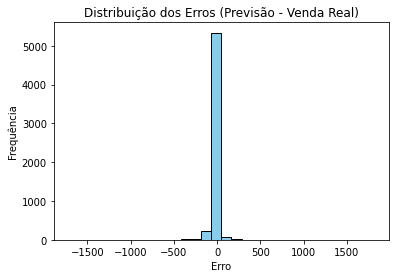

In [19]:
# Calculando MAE por categoria de volume
mae_por_volume = performance_final.groupby('categoria_volume', observed=False).apply(lambda x: np.mean(np.abs(x['erro'])), include_groups=False)
print("MAE por Volume:\n", mae_por_volume)

# Distribuição dos erros
# Tem 2 outliers com erros bem altos que removi da base para não poluir o gráfico
plt.hist(performance_final.loc[performance_final['erro'] > -2000]['erro'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição dos Erros (Previsão - Venda Real)')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.show()

c:\Users\rafae\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


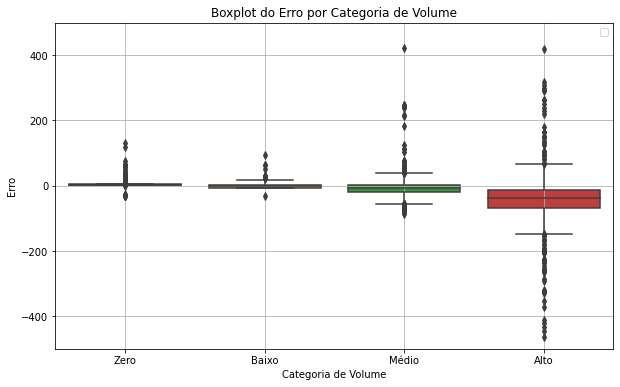

In [20]:
# Criando o boxplot
# Tem 2 outliers com erros bem altos que removi da base para não poluir o gráfico
plt.figure(figsize=(10, 6))
sns.boxplot(x='categoria_volume', y='erro', data=performance_final.loc[performance_final['erro'] > -2000])
plt.title('Boxplot do Erro por Categoria de Volume')
plt.xlabel('Categoria de Volume')
plt.ylabel('Erro')
plt.legend()
plt.grid(True)
plt.ylim(-500, 500)
plt.show()

In [21]:
mean_absolute_error(performance_final['venda'], performance_final['previsao'])

21.690242018038386

In [22]:
# Estatísticas finais
print("Média do Erro Absoluto:", performance_final['erro'].mean())

Média do Erro Absoluto: -8.408448997310217


In [32]:
def forecast_venda(sku):
    # Filtra o DataFrame para encontrar o SKU específico
    previsao = performance_final.loc[performance_final['sku'] == sku, 'previsao']
    
    # Verifica se a previsão foi encontrada
    if not previsao.empty:
        return "A previsão de venda do produto {} é {:.2f}".format(sku, previsao.iloc[0])
    else:
        return "SKU {} não encontrado no conjunto de dados.".format(sku)

In [ ]:
comparativo_previsao = hist_semanal.merge(performance_final[['sku', 'semana_venda', 'previsao']], on=['sku', 'semana_venda'], how='left')
comparativo_previsao.loc[comparativo_previsao['previsao'].isnull(), 'previsao'] = comparativo_previsao.loc[comparativo_previsao['previsao'].isnull()]['venda']

In [46]:
def plot_comparativo_vendas(sku):
    """
    Gera um gráfico comparativo entre as vendas reais e as previsões para um SKU específico.
    
    Parâmetros:
        sku (str): O SKU do produto para o qual o gráfico será gerado.
    """
    # Filtrar o DataFrame para o SKU especificado
    df_sku = comparativo_previsao[comparativo_previsao['sku'] == sku]

    # Verificar se o SKU existe no DataFrame
    if df_sku.empty:
        print(f"SKU {sku} não encontrado no conjunto de dados.")
        return

    # Configurar o tamanho da figura
    plt.figure(figsize=(10, 5))

    # Plotar as vendas reais e previstas
    plt.plot(df_sku['semana_venda'], df_sku['venda'], label='Venda Real', marker="o", color="blue")
    plt.plot(df_sku['semana_venda'], df_sku['previsao'], label='Previsão', marker="o", color="red")

    # Configurações do gráfico
    plt.title(f'Comparação entre Vendas Reais e Previsões para SKU: {sku}', fontsize=16)
    plt.xlabel("Semana de Venda")
    plt.ylabel("Vendas")
    plt.legend()
    plt.tight_layout()

    # Exibir o gráfico
    plt.show()



In [ ]:
forecast_venda(800)

'A previsão de venda do produto 800 é 2.21'

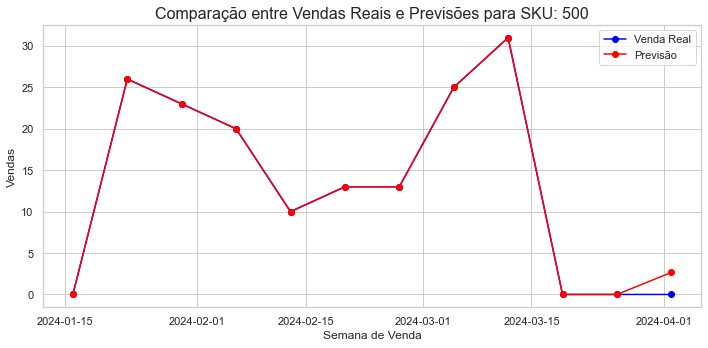

In [51]:
plot_comparativo_vendas(500)